<a href="https://colab.research.google.com/github/Slautin/2025_Co-navigation_CrTaWV-Mo/blob/main/2025_KMC_film_growth_new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# **Kinetic Monte Carlo Diffusion Rate for AₓB₁₋ₓ Film Growth**

In lattice-based kinetic Monte Carlo (kMC) simulations of thin-film deposition,
surface diffusion is represented as a thermally activated hopping process.  
Each possible hop between nearest-neighbor sites is assigned a *physical* rate,
and the kMC algorithm statistically selects hops according to these rates.

This cell summarizes the **theory of the diffusion hop rate**, including  
broken-bond energetics and step-edge effects (downhill slip and uphill barriers).

---

## **1. Arrhenius Form of the Diffusion Rate**

A hop from site $ i $ to site $ j $ occurs with the rate

$$
r_{i \rightarrow j} = \nu_0 \exp\!\left( -\frac{E_{\mathrm{diff}}(i \rightarrow j)}{k_B T} \right),
$$

where:

- $ \nu_0 $ — attempt frequency (typically $10^{12}–10^{13}\,\text{s}^{-1}$),
- $ k_B $ — Boltzmann constant,
- $ T $ — temperature,
- $ E_{\mathrm{diff}} $ — diffusion activation barrier.

The attempt frequency $ \nu_0 $ sets the *absolute timescale*.  
Relative diffusion probabilities depend entirely on the barrier differences.

---

## **2. Diffusion Barrier: Broken-Bond Model**

During a hop, the diffusing atom breaks bonds with its neighbors.  
These contribute additively to the barrier:

$$
E_{\mathrm{diff}}
=
E_0
+ n_{AA} E_{AA}
+ n_{BB} E_{BB}
+ n_{AB} E_{AB}
+ E_{\mathrm{step}}.
$$

**Terms:**

- $ E_0 $ — intrinsic barrier for hopping on a flat terrace with no neighbors,
- $ E_{AA}, E_{BB}, E_{AB} $ — effective bond energies (A–A, B–B, A–B),
- $ n_{AA}, n_{BB}, n_{AB} $ — number of such bonds broken during the hop.

Typical bond energies in lattice growth models: **0.05–0.4 eV**.

This term governs alloy mixing, clustering, ordering, and local stability.

---

## **3. Step-Edge Effects: Slip-Down and Slip-Up**

Surface height differences modify the diffusion barrier.  
Define the height change:

$$
\Delta h = h_{\mathrm{target}} - h_{\mathrm{origin}}.
$$

Then the step contribution is:

### **Downhill Slip (Slip-Down, $ \Delta h < 0 $)**
Atoms hopping down a step gain binding energy:

$$
E_{\mathrm{step}} = -\Delta E_{\mathrm{down}},
$$

with $ \Delta E_{\mathrm{down}} > 0 $ (typically 0.05–0.15 eV).

### **Flat Terrace Hop ( $ \Delta h = 0 $ )**
No step edge influence:

$$
E_{\mathrm{step}} = 0.
$$

### **Uphill Hop (Slip-Up / Ehrlich–Schwoebel Barrier, $ \Delta h > 0 $)**
Atoms hopping up a step must overcome an extra barrier:

$$
E_{\mathrm{step}} = +E_{\mathrm{ES}},
$$

with $ E_{\mathrm{ES}} $ typically 0.1–0.3 eV.

These effects determine mound formation, smooth layer growth, and terrace-width evolution.

---

## **4. Complete Expression for the Diffusion Barrier**

Combining all contributions yields the full physically grounded barrier:

$$
\boxed{
E_{\mathrm{diff}}
=
E_0
+ n_{AA} E_{AA}
+ n_{BB} E_{BB}
+ n_{AB} E_{AB}
+
\begin{cases}
-\Delta E_{\mathrm{down}}, & \Delta h < 0, \\[6pt]
0, & \Delta h = 0, \\[6pt]
+E_{\mathrm{ES}}, & \Delta h > 0.
\end{cases}
}
$$

This barrier is used inside the Arrhenius rate expression and determines how each hop competes with others during the kMC event selection.

---

## **5. Physical Interpretation**

- **Slip-down** accelerates downhill diffusion → smoother films.  
- **Ehrlich–Schwoebel barriers** suppress uphill motion → mound growth.  
- **Bond-counting terms** determine A/B mixing, clustering, phase separation, or ordering.  
- **Intrinsic barrier $E_0$** sets the baseline mobility on terraces.

Together, this model provides a realistic and flexible theoretical description of  
surface diffusion during thin-film growth in sputtering, MBE, and evaporation.



In [ ]:
def hex_lattice(nx=10, ny=5, a=1.0):
    """
    Generate coordinates of a 2D hexagonal (triangular) lattice.

    n: number of points along each index direction
    a: lattice constant (spacing)
    """

    coords = np.zeros((ny,nx,2))
    dy = np.sqrt(3)/2 * a
    for j in range(ny):
        y = j * dy
        x_shift = (j % 2) * (a/2)   # shift odd rows
        for i in range(nx):
            x = i * a + x_shift
            coords[j,i] = np.array([x, y])
            # coords_ij.append((j,i))
    return np.array(coords)


def hex_neighbors(i, j, max_bound = None):
    """
    Get the 6 nearest neighbors of a site (i, j) in a hexagonal (triangular) lattice
    represented as staggered rows.

    Parameters
    ----------
    i, j : int
        Lattice indices of the node (column, row).

    periodic : bool, default False
        If True, apply periodic boundary conditions. If False, neighbors
        outside the [0, nx), [0, ny) region are excluded.

    Returns
    -------
    neighbors : list of (int, int)
        List of 6 neighbor indices.
    """
    # Row parity (even or odd)
    if i % 2 == 1:  # even row
        neigh = [(i-1, j), (i+1, j),
                 (i, j-1), (i+1, j+1),
                 (i, j+1), (i-1, j+1)]
    else:  # odd row
        neigh = [(i-1, j), (i+1, j),
                 (i, j-1), (i+1, j-1),
                 (i, j+1), (i-1, j-1)]

    valid = []
    for ni, nj in neigh:
        # Always check non-negativity
        if ni < 0 or nj < 0:
            continue
        # Check boundaries if provided
        if max_bound is not None:
            nx, ny = max_bound
            if ni >= nx or nj >= ny:
                continue
        valid.append((ni, nj))

    return np.array(valid).astype(int)

def particle_generator(atoms, probs):
  while True:
    yield np.random.choice(atoms, p=probs)

def first_false_indices(arr: np.ndarray) -> np.ndarray:
    """
    Return an array of shape (k, 2) with (i, j) for columns that contain at least one False,
    where i is the minimal row index with arr[i, j] == False.
    """
    # Find rows that contain at least one False
    #false_mask = ~arr
    has_false = (arr == 0).any(axis=0)
    js = np.nonzero(has_false)[0]
    is_ = np.argmin(arr[:, js], axis=0)
    return np.column_stack((is_, js))

def surface_roughness(image_2d, norm_coef=1):
    """
    Compute RMS roughness of a 2D array.
    """
    mean_val = np.mean(image_2d)
    rms = np.sqrt(np.mean((image_2d - mean_val) ** 2))
    return rms*norm_coef

def hop_rate(E_diff, nu0, T):
    """
    Computes the physical diffusion hop rate for kMC.

    Parameters:
        Ediff
        EAB  : bond energy for A-B (eV)
        nu0  : attempt frequency (Hz), typically 1e12–1e13
        T    : temperature (K)

    Returns:
        rate : physical transition rate (1/s)
    """
    kB = 8.617333262e-5  # Boltzmann constant in eV/K

    # broken-bond diffusion barrier

    # Arrhenius rate
    rate = nu0 * np.exp( -E_diff / (kB * T) )

    return rate

def sputtering(
    film,
    dE,
    atoms,
    flow,
    t,
    n_hops = 3,
    dist = 2,
    E0=.2,
    k_up = 0.02,
    k_down = .1,
    T=700

):
  rng = np.random.default_rng()
  film_r = film.copy()

  atom_types = {}
  for i, a in enumerate(atoms):
    atom_types[int(i+1)] = a

  flow = np.full(len(atom_types), flow)
  sputtered_particles = int(np.sum(flow)*t)

  # Normalize flow to make it a probability distribution
  prob = flow / flow.sum()
  atom_count = np.arange(len(atom_types))+1
  # Draw samples with probabilities `prob`
  particle_flow = np.random.choice(atom_count, size=sputtered_particles, replace=True, p=prob)

  dE_sorted = {tuple(sorted(k)): v for k, v in dE.items()}

  for p in particle_flow:
    surf_indexes = first_false_indices(film_r)
    idx = rng.integers(len(surf_indexes))
    loc = surf_indexes[idx]
    for _ in range(n_hops):
      if loc[0] == 0:
        pass
      else:
        rates = np.array([])
        distance = np.linalg.norm(surf_indexes[:,1].reshape(1,-1) - loc[1], axis=0)
        neighb_surf = surf_indexes[(distance<dist)]
        for n_loc in neighb_surf:
          dh = n_loc[0] - loc[0]
          if dh > 0:
            es = k_up*dh
          else:
            es = k_down
          neighbours = hex_neighbors(*n_loc, max_bound=film_r.shape)
          n_atoms = film_r[neighbours[:, 0], neighbours[:, 1]]
          unique_neighbours, counts = np.unique(n_atoms, return_counts=True)
          Ediff = E0 + np.sign(dh)*es
          for u, c in zip(unique_neighbours, counts):
              if u != 0:
                key_Ea = tuple(sorted((atom_types[u],atom_types[p])))
                Ea_up = dE_sorted[key_Ea]
                Ediff += Ea_up*c
          #print('Ed ', Ediff)
          rr = hop_rate(Ediff, 1, T)
          #print(rr)
          rates = np.append(rates, rr)
        prob_hop = rates/np.sum(rates)
        event = np.random.choice(np.arange(len(neighb_surf)), p=prob_hop)
        loc = neighb_surf[event]
    film_r[*loc]=p
  return film_r

In [ ]:
atoms =['A', 'B']
nodes= hex_lattice(nx=200, ny=200)

x=0.5
t=100

E0 = .2
n_hopes = 3

dE ={('A','A'): 5e-2,
    ('A', 'B'): 10e-2,
    ('B','B'): 1e-2}

# 1. Temperature

In [ ]:
atoms =['A', 'B']
nodes= hex_lattice(nx=300, ny=200)

x=0.5
t=100

E0 = .2
n_hopes = 3

dE ={('A','A'): 5e-2,
    ('A', 'B'): 10e-2,
    ('B','B'): 1e-2}

In [ ]:
xx = np.linspace(0,1,10)
tt = np.array([400, 500, 700])

srrr = []
for T in tt:
  srr = np.array([])
  for x in xx:
    film = np.zeros(nodes.shape[:-1]).astype(int)
    flow = np.array([x*100.,(1-x)*100.])
    film = sputtering(film, dE, flow, t, dist = 2, k_up=0.15, k_down=.1, T=T)
    sr = surface_roughness(np.argmin((film > 0), axis=0), norm_coef=1)
    print(f'Composition: {x}, Roughness: {round(sr, 3)}')
    srr = np.append(srr, sr)
  srrr.append(srr)

Composition: 0.0, Roughness: 1.164
Composition: 0.1111111111111111, Roughness: 1.775
Composition: 0.2222222222222222, Roughness: 2.651
Composition: 0.3333333333333333, Roughness: 2.997
Composition: 0.4444444444444444, Roughness: 3.383
Composition: 0.5555555555555556, Roughness: 3.453
Composition: 0.6666666666666666, Roughness: 3.555
Composition: 0.7777777777777777, Roughness: 3.75
Composition: 0.8888888888888888, Roughness: 3.632
Composition: 1.0, Roughness: 2.63
Composition: 0.0, Roughness: 1.223
Composition: 0.1111111111111111, Roughness: 1.704
Composition: 0.2222222222222222, Roughness: 2.395
Composition: 0.3333333333333333, Roughness: 2.476
Composition: 0.4444444444444444, Roughness: 3.123
Composition: 0.5555555555555556, Roughness: 3.387
Composition: 0.6666666666666666, Roughness: 3.476
Composition: 0.7777777777777777, Roughness: 3.12
Composition: 0.8888888888888888, Roughness: 2.788
Composition: 1.0, Roughness: 2.089
Composition: 0.0, Roughness: 1.347
Composition: 0.1111111111111

Text(0, 0.5, 'Roughness')

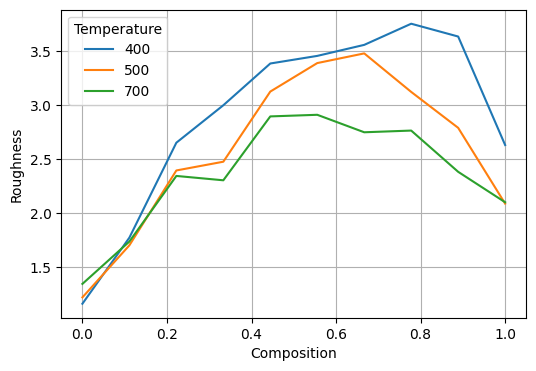

In [ ]:
fig = plt.figure(figsize=(6,4))

for i,line in enumerate(srrr):
  plt.plot(xx, line, label=tt[i])
plt.legend(title='Temperature')
plt.grid()

plt.xlabel('Composition')
plt.ylabel('Roughness')


# 2. n_hops

In [ ]:
atoms =['A', 'B']
nodes= hex_lattice(nx=300, ny=200)

x=0.5
t=100

E0 = .2
n_hopes = 3

dE ={('A','A'): 5e-2,
    ('A', 'B'): 10e-2,
    ('B','B'): 1e-2}

T = 700

In [ ]:
xx = np.linspace(0,1,10)
n_hops_ar = np.array([3,5,7])

srrr = []
for n_h in n_hops_ar:
  srr = np.array([])
  for x in xx:
    film = np.zeros(nodes.shape[:-1]).astype(int)
    flow = np.array([x*100.,(1-x)*100.])
    film = sputtering(film, dE, flow, t, dist = 2, k_up=0.15, k_down=.1,
                      T=700, n_hopes=n_h)
    sr = surface_roughness(np.argmin((film > 0), axis=0), norm_coef=1)
    print(f'Composition: {x}, Roughness: {round(sr, 3)}')
    srr = np.append(srr, sr)
  srrr.append(srr)

Composition: 0.0, Roughness: 1.164
Composition: 0.1111111111111111, Roughness: 1.759
Composition: 0.2222222222222222, Roughness: 1.861
Composition: 0.3333333333333333, Roughness: 2.285
Composition: 0.4444444444444444, Roughness: 2.628
Composition: 0.5555555555555556, Roughness: 2.564
Composition: 0.6666666666666666, Roughness: 2.951
Composition: 0.7777777777777777, Roughness: 2.797
Composition: 0.8888888888888888, Roughness: 2.498
Composition: 1.0, Roughness: 1.924
Composition: 0.0, Roughness: 0.981
Composition: 0.1111111111111111, Roughness: 1.9
Composition: 0.2222222222222222, Roughness: 1.987
Composition: 0.3333333333333333, Roughness: 2.327
Composition: 0.4444444444444444, Roughness: 2.512
Composition: 0.5555555555555556, Roughness: 2.651
Composition: 0.6666666666666666, Roughness: 2.321
Composition: 0.7777777777777777, Roughness: 2.278
Composition: 0.8888888888888888, Roughness: 2.707
Composition: 1.0, Roughness: 1.656
Composition: 0.0, Roughness: 1.034
Composition: 0.111111111111

Text(0, 0.5, 'Roughness')

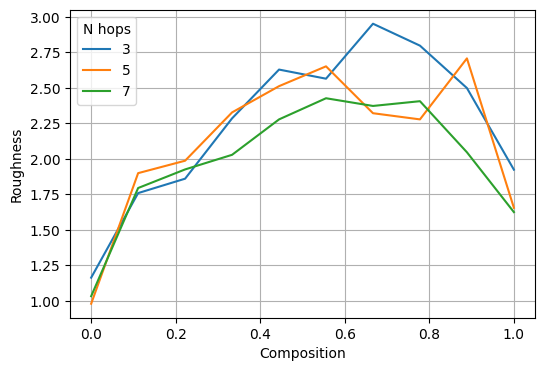

In [ ]:
fig = plt.figure(figsize=(6,4))

for i,line in enumerate(srrr):
  plt.plot(xx, line, label=n_hops_ar[i])
plt.legend(title='N hops')
plt.grid()

plt.xlabel('Composition')
plt.ylabel('Roughness')


# 3 Eaa

In [ ]:
atoms =['A', 'B']
nodes= hex_lattice(nx=300, ny=200)

x=0.5
t=100

E0 = .2
n_hopes = 3

dE ={('A','A'): 5e-2,
    ('A', 'B'): 10e-2,
    ('B','B'): 1e-2}

T = 700

In [ ]:
xx = np.linspace(0,1,10)
eaa = np.array([1e-2, 3e-2, 5e-2, 7e-2, 10e-2])

srrr = []
for ea in eaa:
  dE ={('A','A'): ea,
    ('A', 'B'): 10e-2,
    ('B','B'): 1e-2}
  srr = np.array([])
  for x in xx:
    film = np.zeros(nodes.shape[:-1]).astype(int)
    flow = np.array([x*100.,(1-x)*100.])
    film = sputtering(film, dE, flow, t, dist = 2, k_up=0.15, k_down=.1,
                      T=700)
    sr = surface_roughness(np.argmin((film > 0), axis=0), norm_coef=1)
    print(f'Composition: {x}, Roughness: {round(sr, 3)}')
    srr = np.append(srr, sr)
  srrr.append(srr)

Composition: 0.0, Roughness: 1.223
Composition: 0.1111111111111111, Roughness: 1.873
Composition: 0.2222222222222222, Roughness: 1.825
Composition: 0.3333333333333333, Roughness: 2.069
Composition: 0.4444444444444444, Roughness: 2.272
Composition: 0.5555555555555556, Roughness: 1.725
Composition: 0.6666666666666666, Roughness: 2.048
Composition: 0.7777777777777777, Roughness: 1.852
Composition: 0.8888888888888888, Roughness: 2.077
Composition: 1.0, Roughness: 1.263
Composition: 0.0, Roughness: 1.161
Composition: 0.1111111111111111, Roughness: 1.721
Composition: 0.2222222222222222, Roughness: 2.21
Composition: 0.3333333333333333, Roughness: 2.59
Composition: 0.4444444444444444, Roughness: 2.347
Composition: 0.5555555555555556, Roughness: 2.229
Composition: 0.6666666666666666, Roughness: 2.424
Composition: 0.7777777777777777, Roughness: 2.168
Composition: 0.8888888888888888, Roughness: 1.908
Composition: 1.0, Roughness: 1.438
Composition: 0.0, Roughness: 1.156
Composition: 0.111111111111

Text(0, 0.5, 'Roughness')

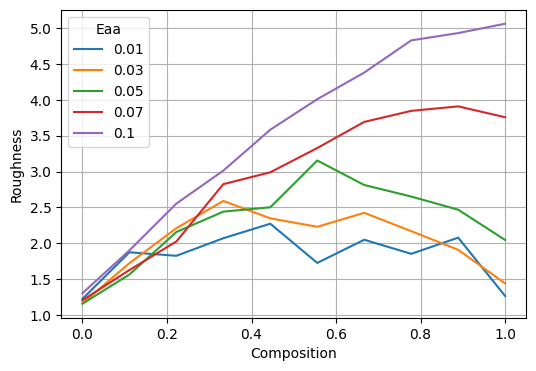

In [ ]:
fig = plt.figure(figsize=(6,4))

for i,line in enumerate(srrr):
  plt.plot(xx, line, label=eaa[i])
plt.legend(title='Eaa')
plt.grid()

plt.xlabel('Composition')
plt.ylabel('Roughness')

# 4 Eab

In [ ]:
atoms =['A', 'B']
nodes= hex_lattice(nx=400, ny=200)

x=0.5
t=150

E0 = .2
n_hopes = 3

dE ={('A','A'): 5e-2,
    ('A', 'B'): 10e-2,
    ('B','B'): 1e-2}

T = 700

In [ ]:
xx = np.linspace(0,1,10)
eab = np.array([1e-2, 3e-2, 5e-2, 7e-2, 10e-2])

srrr = []
for e_ab in eab:
  dE ={('A','A'): 5e-2,
    ('A', 'B'): e_ab,
    ('B','B'): 1e-2}
  srr = np.array([])
  for x in xx:
    film = np.zeros(nodes.shape[:-1]).astype(int)
    flow = np.array([x*100.,(1-x)*100.])
    film = sputtering(film, dE, flow, t, dist = 2, k_up=0.15, k_down=.1,
                      T=700)
    sr = surface_roughness(np.argmin((film > 0), axis=0), norm_coef=1)
    print(f'Composition: {x}, Roughness: {round(sr, 3)}')
    srr = np.append(srr, sr)
  srrr.append(srr)

Composition: 0.0, Roughness: 1.437
Composition: 0.1111111111111111, Roughness: 1.334
Composition: 0.2222222222222222, Roughness: 1.4
Composition: 0.3333333333333333, Roughness: 1.402
Composition: 0.4444444444444444, Roughness: 1.362
Composition: 0.5555555555555556, Roughness: 1.508
Composition: 0.6666666666666666, Roughness: 1.535
Composition: 0.7777777777777777, Roughness: 1.871
Composition: 0.8888888888888888, Roughness: 1.713
Composition: 1.0, Roughness: 2.374
Composition: 0.0, Roughness: 1.407
Composition: 0.1111111111111111, Roughness: 1.713
Composition: 0.2222222222222222, Roughness: 1.598
Composition: 0.3333333333333333, Roughness: 1.718
Composition: 0.4444444444444444, Roughness: 1.321
Composition: 0.5555555555555556, Roughness: 1.465
Composition: 0.6666666666666666, Roughness: 1.391
Composition: 0.7777777777777777, Roughness: 1.766
Composition: 0.8888888888888888, Roughness: 1.815
Composition: 1.0, Roughness: 1.765
Composition: 0.0, Roughness: 1.565
Composition: 0.111111111111

Text(0, 0.5, 'Roughness')

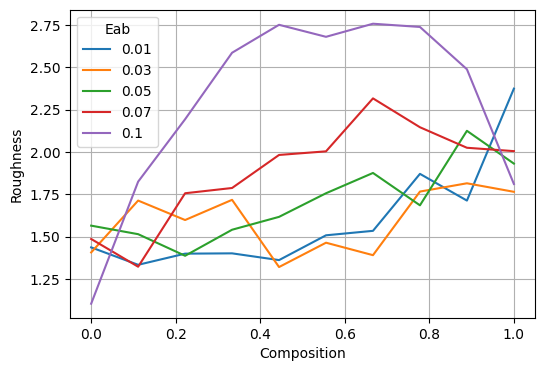

In [ ]:
fig = plt.figure(figsize=(6,4))

for i,line in enumerate(srrr):
  plt.plot(xx, line, label=eaa[i])
plt.legend(title='Eab')
plt.grid()

plt.xlabel('Composition')
plt.ylabel('Roughness')

# Comparing with the experiment

In [ ]:
! gdown  https://drive.google.com/file/d/1SjNbzmHefx1Wa9W_2MbidDnx7TFdMYB7/view?usp=sharing --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1SjNbzmHefx1Wa9W_2MbidDnx7TFdMYB7
From (redirected): https://drive.google.com/uc?id=1SjNbzmHefx1Wa9W_2MbidDnx7TFdMYB7&confirm=t&uuid=50259dcd-eec6-4cfe-b33a-0ff18fe5c25b
To: /content/CTWWV-Mo_min.npz
100% 102M/102M [00:00<00:00, 125MB/s] 


In [ ]:
data = np.load("/content/CTWWV-Mo_min.npz")
data_dict = {key: data[key] for key in data.files}

In [ ]:
roughness_array = []
for key in data_dict:
  r = surface_roughness(data_dict[key])
  roughness_array.append([float(key), r*1e9])

roughness_array = np.array(roughness_array)

roughness_array[:,0] = 1 - (roughness_array[:,0] -  np.min(roughness_array[:,0]))/ np.ptp(roughness_array[:,0])

In [ ]:
import torch
from torch import tensor as tt

In [ ]:
atoms =['A', 'B']
nodes= hex_lattice(nx=300, ny=200)

x=0.5
t=100

E0 = .2
n_hopes = 3

dE ={('A','A'): 5e-2,
    ('A', 'B'): 10e-2,
    ('B','B'): 1e-2}

T = 700

In [ ]:
srr = np.array([])
xx = np.linspace(0,1,30)

for x in xx:
  film = np.zeros(nodes.shape[:-1]).astype(int)
  flow = np.array([x*100.,(1-x)*100.])
  film = sputtering(film, dE, flow, t, dist = 2, k_up=0.15, k_down=.1, T=700)
  sr = surface_roughness(np.argmin((film > 0), axis=0), norm_coef=1)
  print(f'Composition: {x}, Roughness: {round(sr, 3)}')
  srr = np.append(srr, sr)

Composition: 0.0, Roughness: 1.37
Composition: 0.034482758620689655, Roughness: 1.588
Composition: 0.06896551724137931, Roughness: 1.417
Composition: 0.10344827586206896, Roughness: 1.609
Composition: 0.13793103448275862, Roughness: 2.171
Composition: 0.1724137931034483, Roughness: 1.791
Composition: 0.20689655172413793, Roughness: 1.991
Composition: 0.24137931034482757, Roughness: 2.297
Composition: 0.27586206896551724, Roughness: 2.089
Composition: 0.3103448275862069, Roughness: 2.455
Composition: 0.3448275862068966, Roughness: 2.439
Composition: 0.3793103448275862, Roughness: 2.567
Composition: 0.41379310344827586, Roughness: 2.813
Composition: 0.4482758620689655, Roughness: 2.642
Composition: 0.48275862068965514, Roughness: 2.478
Composition: 0.5172413793103449, Roughness: 2.73
Composition: 0.5517241379310345, Roughness: 2.721
Composition: 0.5862068965517241, Roughness: 2.645
Composition: 0.6206896551724138, Roughness: 2.796
Composition: 0.6551724137931034, Roughness: 2.858
Composi

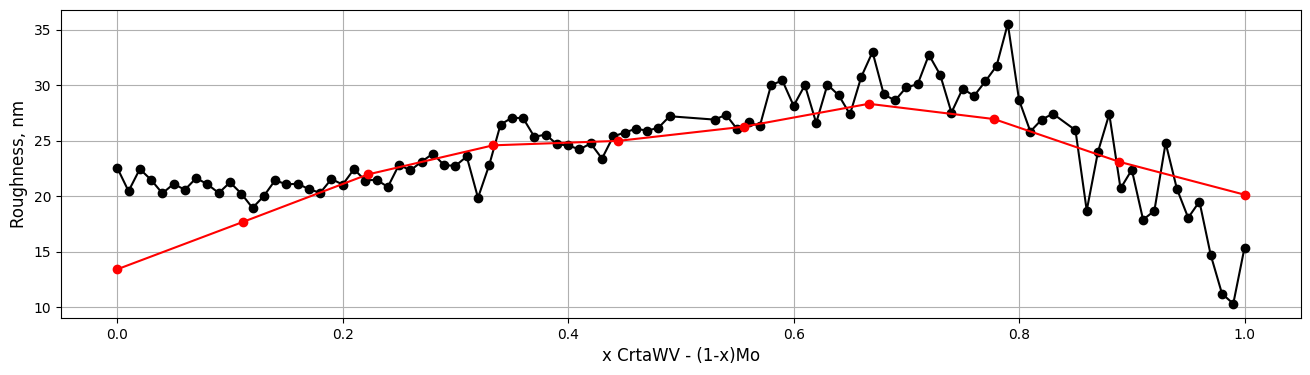

In [ ]:
fig = plt.figure(figsize=(16, 4))

plt.plot(*roughness_array.T, 'ko-', )
plt.plot(xx, srr*10, 'ro-', )


plt.ylabel('Roughness, nm', fontsize=12)
plt.xlabel("x CrtaWV - (1-x)Mo", fontsize=12)
plt.grid()

# 5. Ground truth

In [ ]:
import torch
from torch import tensor as tt

In [ ]:
def theory_calculation(x, sputtering_params, rough_norm_coef=10):
  flow = tt([x*100., (1-x)*100.])
  sputtering_params['flow'] = flow
  film_r = sputtering(**sputtering_params)
  sr = surface_roughness(np.argmin((film_r > 0), axis=0), rough_norm_coef)
  return sr, film_r


In [ ]:
t = 100            #sputtering duration (100 particles/s for each particle type)
E0 = .2
n_hops = 3
T = 700

k_up = .15
k_down = .1
dist = 2

atoms=['A', 'B']
nodes= hex_lattice(nx=300, ny=200)

X = tt(np.linspace(0,1,10)) #composition T

In [ ]:
E = np.array(
    [[1e-2, 5e-2, 10e-2],
     [10e-2, 1e-2,  5e-2],
     [1e-2, 10e-2,  1e-2]]
)

dict_res = []

for e in E:
  print(f'----dE: {e} -----')
  dE = {('A', 'A'): e[0],
        ('A', 'B'): e[1],
        ('B', 'B'): e[2]}


  sputtering_params = {
      'film': np.zeros(nodes.shape[:-1]).astype(int),
      'dE': dE,
      'atoms': atoms,
      't': t,
      'n_hops': n_hops,
      'dist': dist,
      'E0': E0,
      'k_up': k_up,
      'k_down': k_down,
      'T':T,
      }

  films, sr = [], []
  for x in X:
    print(f'----x: {x} -----')
    _sr = []
    for i in range(5):
      print(f'-- iter {i} --')
      _sr0, film_r = theory_calculation(x, sputtering_params,
                                        rough_norm_coef=10)
      print(f'Roughness: {_sr0}')
      _sr.append(_sr0)


    films.append(film_r)
    sr.append(np.array(_sr))

  dict_res.append(
      {'dE': dE,
       'sput_params': sputtering_params,
       'films': films,
       'Roughness': sr
       }
  )



----dE: [0.01 0.05 0.1 ] -----
----x: 0.0 -----
-- iter 0 --
Roughness: 57.48816303282693
-- iter 1 --
Roughness: 53.58067645046009
-- iter 2 --
Roughness: 53.011529144349566
-- iter 3 --
Roughness: 51.79661078573471
-- iter 4 --
Roughness: 50.26816973880081
----x: 0.1111111111111111 -----
-- iter 0 --
Roughness: 45.667883195475085
-- iter 1 --
Roughness: 48.732831734764694
-- iter 2 --
Roughness: 45.908120801831515
-- iter 3 --
Roughness: 43.2691832858239
-- iter 4 --
Roughness: 44.68656273298372
----x: 0.2222222222222222 -----
-- iter 0 --
Roughness: 33.93457758033176
-- iter 1 --
Roughness: 41.73993557999608
-- iter 2 --
Roughness: 36.64544840616483
-- iter 3 --
Roughness: 38.98147708278324
-- iter 4 --
Roughness: 39.10100879630714
----x: 0.3333333333333333 -----
-- iter 0 --
Roughness: 31.74201561897977
-- iter 1 --
Roughness: 29.578520735305357
-- iter 2 --
Roughness: 33.41988762531808
-- iter 3 --
Roughness: 30.95516470998373
-- iter 4 --
Roughness: 28.77885025886584
----x: 0.444

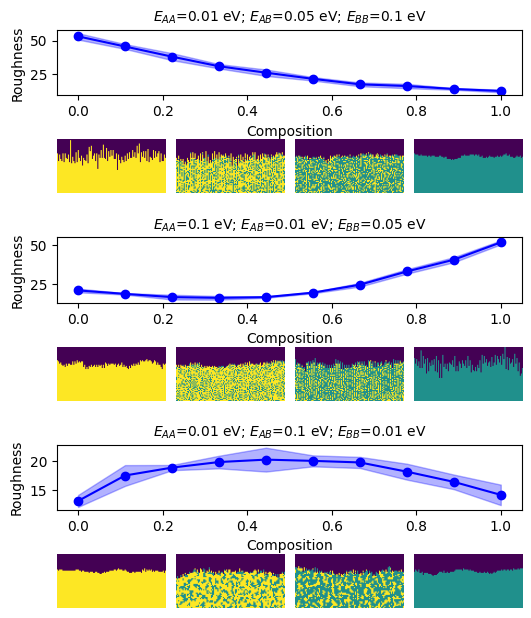

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
nn = 100
cmap='viridis'

fig = plt.figure(figsize=(6, 8))
gs = GridSpec(6, 4,
              figure=fig,
              hspace=0.06,         # vertical spacing between rows
              wspace=0.1,
              height_ratios=[0.5, 1, 0.5, 1, 0.5, 1])


ax = {}

# --- Row 0 spanning full width ---
ax[0] = fig.add_subplot(gs[0, :])
ax[0].fill_between(X,
                   np.array(dict_res[0]['Roughness']).mean(1) - np.array(dict_res[0]['Roughness']).std(1),
                   np.array(dict_res[0]['Roughness']).mean(1) + np.array(dict_res[0]['Roughness']).std(1),
                   alpha=.3,
                   color = 'blue')
ax[0].plot(X, np.array(dict_res[0]['Roughness']).mean(1), 'o-',
           c = 'blue')
ax[0].set_xlabel('Composition', y=1)
ax[0].set_ylabel('Roughness')
ax[0].set_title('$E_{AA}$='+f'{E[0,0]} eV; '+'$E_{AB}$='+f'{E[0,1]} eV; '+'$E_{BB}$='+f'{E[0,2]} eV',
                fontsize=10)

# --- Row 1: four separate subplots ---
ax[1] = [fig.add_subplot(gs[1, i]) for i in range(4)]
ax[1][0].imshow(dict_res[0]['films'][0][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
ax[1][1].imshow(dict_res[0]['films'][3][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
ax[1][2].imshow(dict_res[0]['films'][6][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
ax[1][3].imshow(dict_res[0]['films'][9][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
for _ in ax[1]:
  _.axis('off')

# --- Row 2 spanning full width ---
ax[2] = fig.add_subplot(gs[2, :])
ax[2].fill_between(X,
                   np.array(dict_res[1]['Roughness']).mean(1) - np.array(dict_res[1]['Roughness']).std(1),
                   np.array(dict_res[1]['Roughness']).mean(1) + np.array(dict_res[1]['Roughness']).std(1),
                   alpha=.3, color='blue')
ax[2].plot(X, np.array(dict_res[1]['Roughness']).mean(1), 'o-',
           color='blue')
ax[2].set_xlabel('Composition')
ax[2].set_ylabel('Roughness')
ax[2].set_title('$E_{AA}$='+f'{E[1,0]} eV; '+'$E_{AB}$='+f'{E[1,1]} eV; '+'$E_{BB}$='+f'{E[1,2]} eV',
                fontsize=10)

# --- Row 3: four separate subplots ---
ax[3] = [fig.add_subplot(gs[3, i]) for i in range(4)]
ax[3][0].imshow(dict_res[1]['films'][0][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
ax[3][1].imshow(dict_res[1]['films'][3][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
ax[3][2].imshow(dict_res[1]['films'][6][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
ax[3][3].imshow(dict_res[1]['films'][9][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
for _ in ax[3]:
  _.axis('off')

# --- Row 4 spanning full width ---
ax[4] = fig.add_subplot(gs[4, :])
ax[4].fill_between(X,
                   np.array(dict_res[2]['Roughness']).mean(1) - np.array(dict_res[2]['Roughness']).std(1),
                   np.array(dict_res[2]['Roughness']).mean(1) + np.array(dict_res[2]['Roughness']).std(1),
                   alpha=.3, color='blue')
ax[4].plot(X, np.array(dict_res[2]['Roughness']).mean(1), 'o-',
           color='blue')
ax[4].set_xlabel('Composition')
ax[4].set_ylabel('Roughness')
ax[4].set_title('$E_{AA}$='+f'{E[2,0]} eV; '+'$E_{AB}$='+f'{E[2,1]} eV; '+'$E_{BB}$='+f'{E[2,2]} eV',
                fontsize=10)

# --- Row 5: four separate subplots ---
ax[5] = [fig.add_subplot(gs[5, i]) for i in range(4)]
ax[5][0].imshow(dict_res[2]['films'][0][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
ax[5][1].imshow(dict_res[2]['films'][3][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
ax[5][2].imshow(dict_res[2]['films'][6][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
ax[5][3].imshow(dict_res[2]['films'][9][:nn//2,:nn], origin='lower', vmin=0, vmax=2, cmap = cmap)
for _ in ax[5]:
  _.axis('off')


plt.show()
fig.savefig('fig2_1.jpg', dpi=300, bbox_inches='tight')